In [9]:
print('Clustering of Kayvans human dataset')

Clustering of Kayvans human dataset


In [10]:
# Setup

import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as sc
from scipy import stats

from collections import OrderedDict
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from matplotlib import cm
from matplotlib.lines import Line2D

def nd(arr):
    return np.asarray(arr).reshape(-1)
def yex(ax):
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]),
            np.max([ax.get_xlim(), ax.get_ylim()])]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
#%config InlineBackend.figure_format = 'retina'

In [11]:
# load the unfiltered matrix
adata = anndata.read_h5ad("output/counts_unfiltered/adata.h5ad")
adata.var["gene_id"] = adata.var.index.values

t2g = pd.read_csv("t2g.txt", header=None, names=["tid", "gene_id", "gene_name"], sep="\t")
t2g.index = t2g.gene_id
t2g = t2g.loc[~t2g.index.duplicated(keep='first')]

adata.var["gene_name"] = adata.var.gene_id.map(t2g["gene_name"])
adata.var.index = adata.var["gene_name"]

In [12]:
adata


AnnData object with n_obs × n_vars = 203066 × 60623
    var: 'gene_id', 'gene_name'

In [15]:
#Parameter settings we use throughout the notebook

num_TSNE = 2
state = 42
metric = "euclidean"
n_neighbors = 30
num_PCA = 50
num_NCA = 10

# Filtering criteria
cell_threshold = 100
gene_threshold = 3

mito_criteria = 30

n_top_genes = 5000

n_bins = 20

flavor="seurat"

In [16]:
adata.obs["cell_counts"] = adata.X.sum(axis=1)
adata.var["gene_counts"] = nd(adata.X.sum(axis=0))

adata.obs["n_genes"] = nd((adata.X>0).sum(axis=1))
adata.var["n_cells"] = nd((adata.X>0).sum(axis=0))

mito_genes = adata.var_names.str.startswith('mt-')
adata.obs["percent_mito"] = adata[:,mito_genes].X.sum(axis=1)/adata.X.sum(axis=1)*100

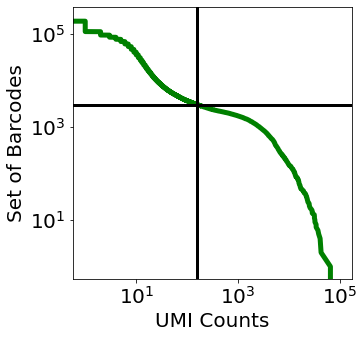

In [17]:
#@title Threshold cells according to knee plot { run: "auto", vertical-output: true }
expected_num_cells = 3000#@param {type:"integer"}
knee = np.sort(nd(adata.X.sum(axis=1)))[::-1]

fig, ax = plt.subplots(figsize=(5, 5))

x = knee
y = range(len(knee))

ax.loglog(x, y, linewidth=5, color="g")

ax.axvline(x=knee[expected_num_cells], linewidth=3, color="k")
ax.axhline(y=expected_num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.show()

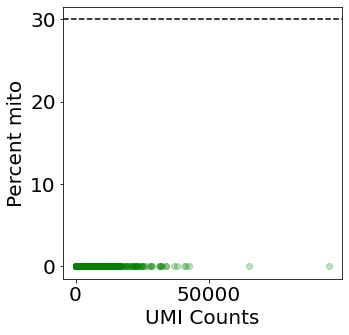

In [18]:
fig, ax = plt.subplots(figsize=(5,5))

x = nd(adata.obs["cell_counts"])
y = nd(adata.obs["percent_mito"])

ax.scatter(x, y, color="green", alpha=0.25)

ax.axhline(y=mito_criteria, linestyle="--", color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Percent mito")

plt.show()

In [19]:
adata.obs["pass_count_filter"] = adata.obs["cell_counts"] > cell_threshold
adata.obs["pass_mito_filter"] = adata.obs.percent_mito < mito_criteria
adata.var["pass_gene_filter"] = adata.var["n_cells"] > gene_threshold

In [20]:
cell_mask = np.logical_and(adata.obs["pass_count_filter"].values, adata.obs["pass_mito_filter"].values)
gene_mask = adata.var["pass_gene_filter"].values

In [21]:
print("Current Shape: {:,} cells x {:,} genes".format(adata.shape[0], adata.shape[1]))
print("    New shape: {:,} cells x {:,} genes".format(cell_mask.sum(), gene_mask.sum()))

Current Shape: 203,066 cells x 60,623 genes
    New shape: 3,632 cells x 27,184 genes


In [22]:
data = adata[cell_mask, gene_mask]

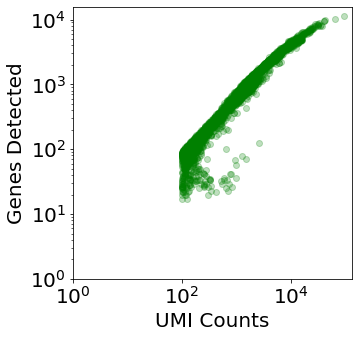

In [23]:
# Create a plot showing genes detected as a function of UMI counts.
fig, ax = plt.subplots(figsize=(5, 5))

x = nd(data.X.sum(axis=1))
y = nd(np.sum(data.X>0, axis=1))

ax.scatter(x, y, color="green", alpha=0.25)

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(1)
ax.set_ylim(1)

plt.show()

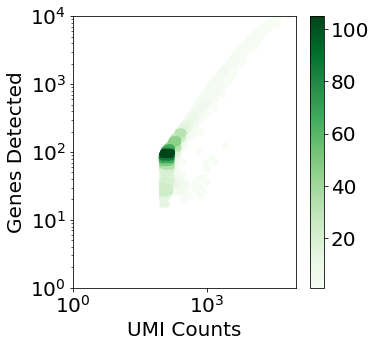

In [24]:
fig, ax = plt.subplots(figsize=(5,5))

#histogram definition
bins = [1500, 1500] # number of bins

# histogram the data
hh, locx, locy = np.histogram2d(x, y, bins=bins)

# Sort the points by density, so that the densest points are plotted last
z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
idx = z.argsort()
x2, y2, z2 = x[idx], y[idx], z[idx]

s = ax.scatter(x2, y2, c=z2, cmap='Greens')  
fig.colorbar(s, ax=ax)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")

ax.set_xlim(1, 10**5)
ax.set_ylim(1, 10**4)

plt.show()

In [25]:
data

View of AnnData object with n_obs × n_vars = 3632 × 27184
    obs: 'cell_counts', 'n_genes', 'percent_mito', 'pass_count_filter', 'pass_mito_filter'
    var: 'gene_id', 'gene_name', 'gene_counts', 'n_cells', 'pass_gene_filter'

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


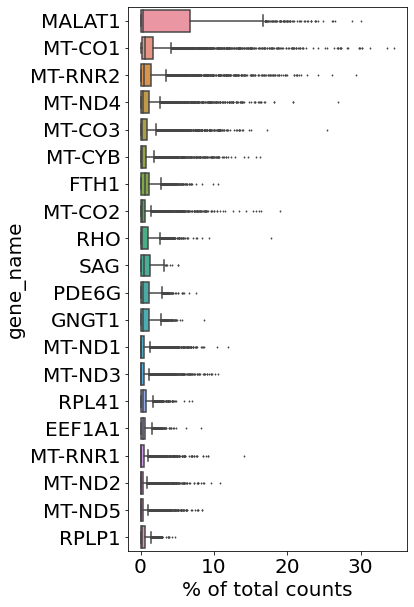

In [26]:
fig, ax = plt.subplots(figsize=(5, 10))
sc.pl.highest_expr_genes(data, n_top=20, ax = ax)

In [27]:
# setup

def vplot(y, ax):
    parts = ax.violinplot(
        y, showmeans=False, showmedians=False,
        showextrema=False)

    mean = y.mean()
    ax.scatter(1, mean, zorder=10, color="white")
    
    x = np.random.normal(1, 0.04, size=len(y))
    ax.scatter(x, y, color="k", s=1)
    
    for pc in parts['bodies']:
        pc.set_facecolor('#D43F3A')
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    
    ax.set_xticks([1])
    ax.set_xticklabels([""])
    return ax

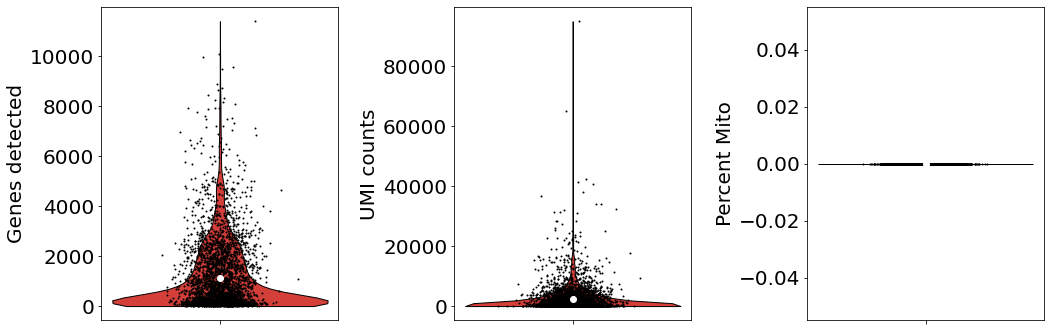

In [28]:
fig, ax = plt.subplots(figsize=(5*3,5), ncols=3)

x1 = data.obs["n_genes"]
x2 = nd(data.X.sum(axis=1))
x3 = data.obs["percent_mito"]

vplot(x1, ax[0])
vplot(x2, ax[1])
vplot(x3, ax[2])

ax[0].set_ylabel("Genes detected")
ax[1].set_ylabel("UMI counts")
ax[2].set_ylabel("Percent Mito")

plt.tight_layout()
plt.show()

In [29]:
data.layers["raw"] = data.X

In [30]:
scale_num = 1000000
data.layers["norm"] = normalize(data.X, norm="l1", axis=1)*scale_num

In [31]:
data.layers["log1p"] = np.log1p(data.layers["norm"])
data.uns = OrderedDict([("log1p", {"base":None})])

In [32]:
data.X = data.layers["log1p"]

In [33]:
sc.pp.highly_variable_genes(data, n_top_genes=n_top_genes, flavor=flavor, n_bins=n_bins)
hvg_mask = data.var.highly_variable.values

In [34]:
#Scaling operation cannot be performed on the sparse matrix, so we make a dense matrix
mat = data.layers["log1p"].todense()
data.layers["scale"] = scale(mat, axis=0, with_mean=True, with_std=True, copy=True)
data.X = data.layers["scale"]

del mat

In [35]:
#PCA
X = data.X[:,hvg_mask]

tsvd = TruncatedSVD(n_components=num_PCA)
data.obsm["X_pca"] = tsvd.fit_transform(X)

In [36]:
#Clustering
sc.pp.neighbors(data, n_neighbors=n_neighbors, n_pcs=num_PCA, random_state=state)

In [37]:
sc.tl.leiden(data, random_state=state)

In [38]:
# t-SNE
X = data.obsm["X_pca"]

tsne = TSNE(n_components=num_TSNE, metric=metric, random_state=state)
data.obsm["X_pca_tsne"] = tsne.fit_transform(X)

In [39]:
# NCA
X = data.X
y = data.obs.leiden.values # you could use louvain here also

nca = NeighborhoodComponentsAnalysis(n_components=num_NCA,random_state=state)
data.obsm["X_nca"] = nca.fit_transform(X, y)

In [40]:
# t-SNE the NCA projection
X = data.obsm["X_nca"]
tsne = TSNE(n_components=num_TSNE, metric=metric, random_state=state)
data.obsm["X_nca_tsne"] = tsne.fit_transform(X)

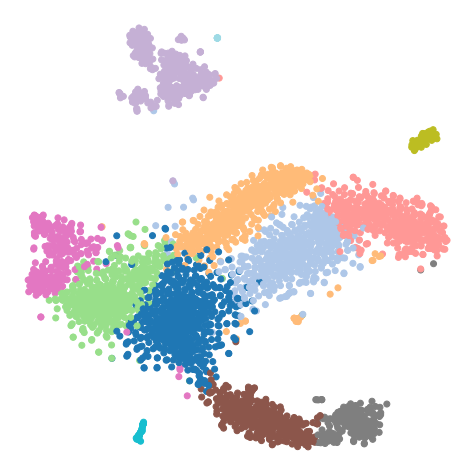

<Figure size 432x288 with 0 Axes>

In [42]:
#PCA followed by t-SNE
fig, ax = plt.subplots(figsize=(7,7))

x = data.obsm["X_pca_tsne"][:,0]
y = data.obsm["X_pca_tsne"][:,1]
c = data.obs["leiden"].astype(int)

ax.scatter(x, y, c = c, cmap='tab20')

ax.set_axis_off()

plt.tight_layout()
plt.show()
plt.savefig('figures/PCA_t_SNE.png')

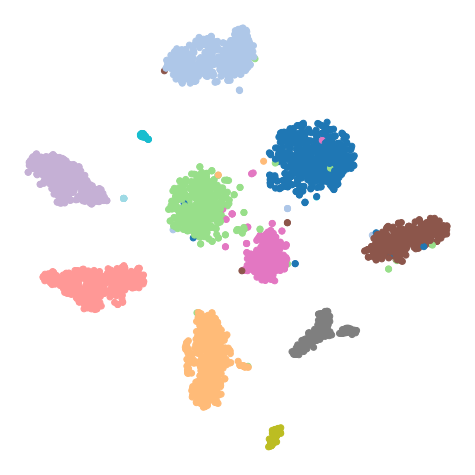

<Figure size 432x288 with 0 Axes>

In [43]:
#NCA followed by t-SNE
fig, ax = plt.subplots(figsize=(7,7))

x = data.obsm["X_nca_tsne"][:,0]
y = data.obsm["X_nca_tsne"][:,1]
c = data.obs["leiden"].astype(int)

ax.scatter(x, y, c = c, cmap='tab20')

ax.set_axis_off()

plt.tight_layout()
plt.show()
plt.savefig('figures/NCA_t_SNE.png')

... storing 'gene_name' as categorical


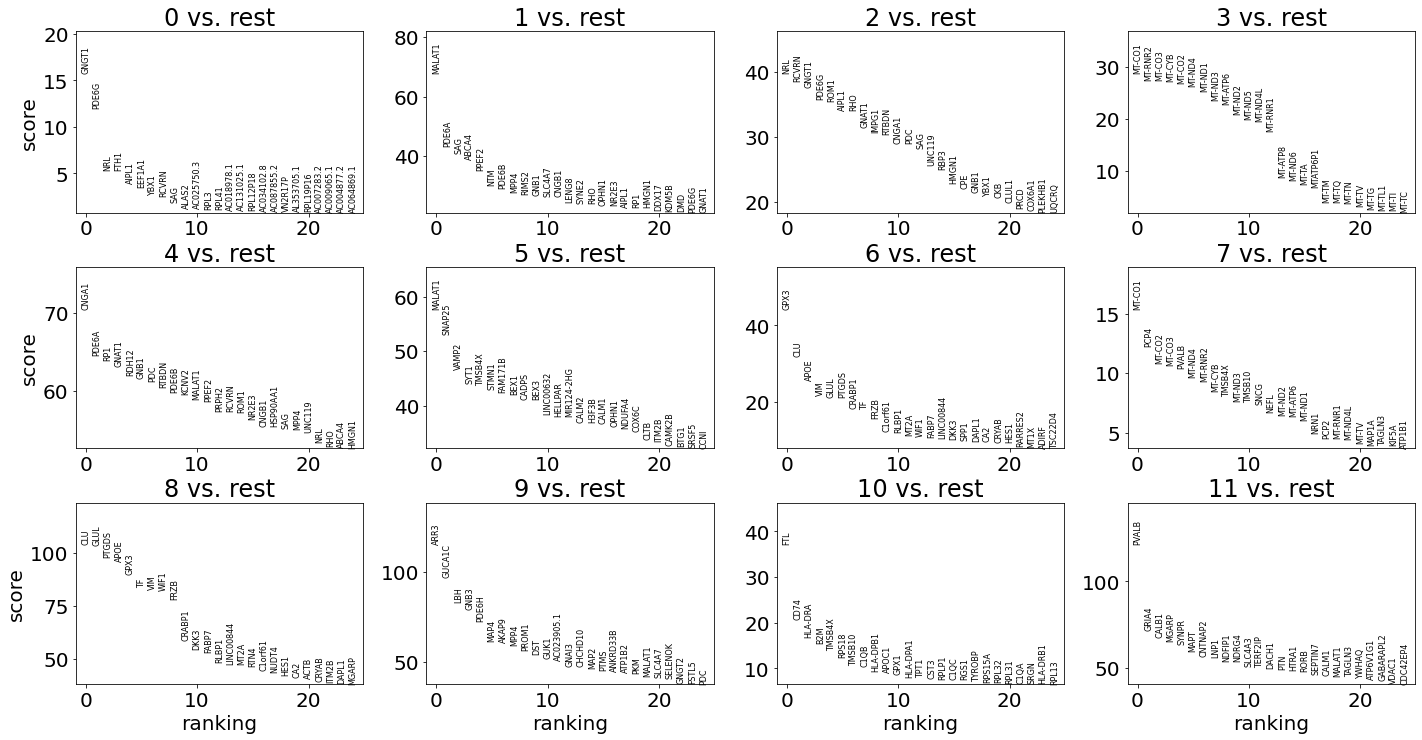

In [44]:
sc.tl.rank_genes_groups(data, 'leiden', method='t-test', corr_method="bonferroni")
sc.pl.rank_genes_groups(data, n_genes=25, sharey=False)

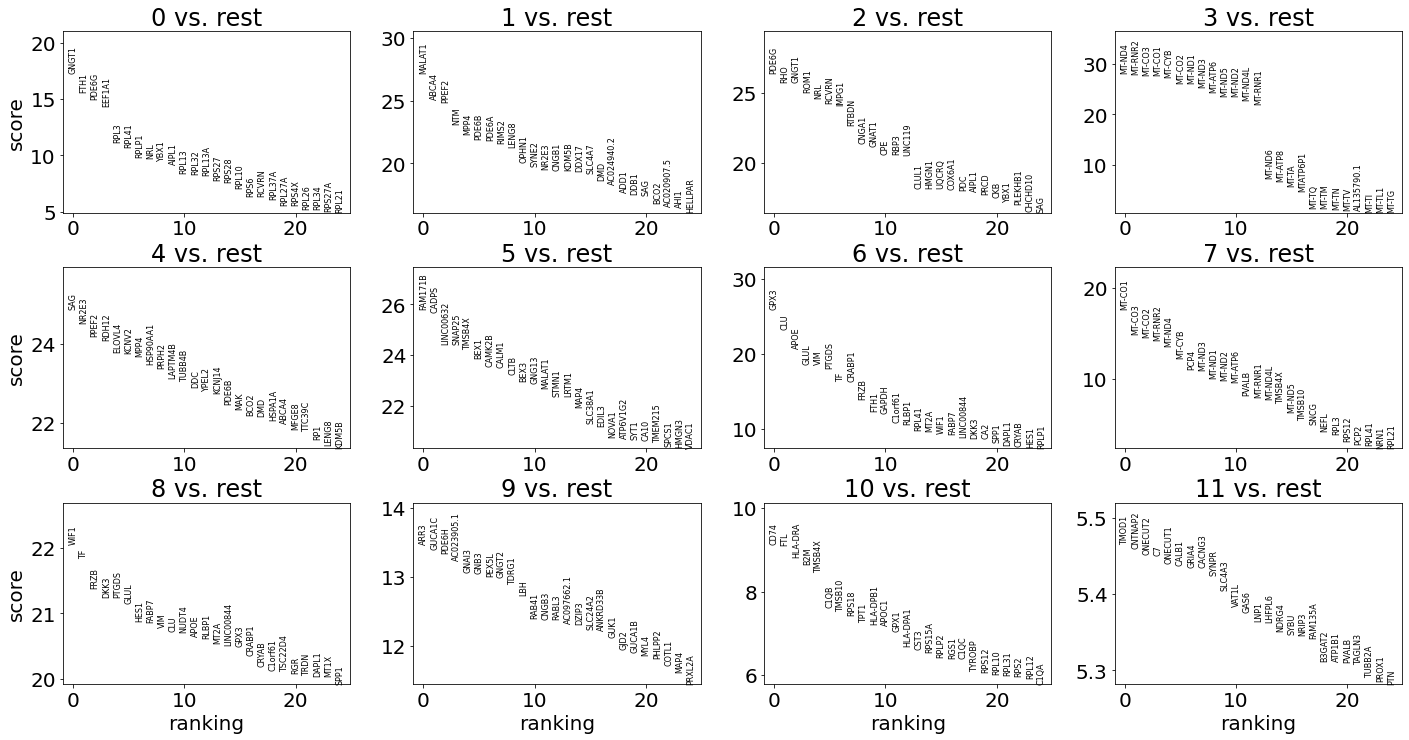

In [45]:
sc.tl.rank_genes_groups(data, 'leiden', method='wilcoxon', corr_method="bonferroni")
sc.pl.rank_genes_groups(data, n_genes=25, sharey=False)

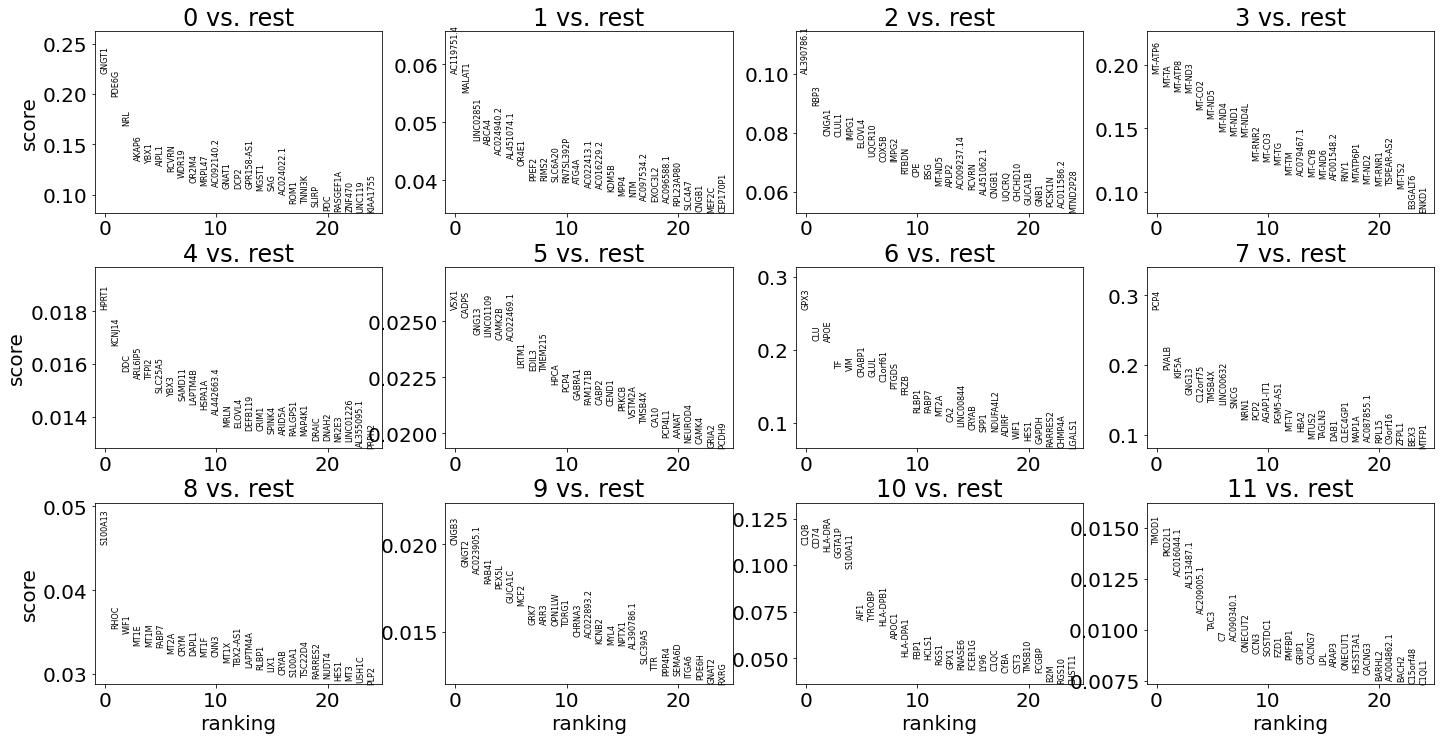

In [46]:
sc.tl.rank_genes_groups(data, 'leiden', method='logreg')
sc.pl.rank_genes_groups(data, n_genes=25, sharey=False)

In [47]:
sc.tl.rank_genes_groups(data, 'leiden', method='wilcoxon', corr_method="bonferroni")

In [48]:
pd.DataFrame(data.uns['rank_genes_groups']['names']).head(10)

,0,1,2,3,4,5,6,7,8,9,10,11
0,GNGT1,MALAT1,PDE6G,MT-ND4,SAG,FAM171B,GPX3,MT-CO1,WIF1,ARR3,CD74,TMOD1
1,FTH1,ABCA4,RHO,MT-RNR2,NR2E3,CADPS,CLU,MT-CO3,TF,GUCA1C,FTL,CNTNAP2
2,PDE6G,PPEF2,GNGT1,MT-CO3,PPEF2,LINC00632,APOE,MT-CO2,FRZB,PDE6H,HLA-DRA,ONECUT2
3,EEF1A1,NTM,ROM1,MT-CO1,RDH12,SNAP25,GLUL,MT-RNR2,DKK3,AC023905.1,B2M,C7
4,RPL3,MPP4,NRL,MT-CYB,ELOVL4,TMSB4X,VIM,MT-ND4,PTGDS,GNAI3,TMSB4X,ONECUT1
5,RPL41,PDE6B,RCVRN,MT-CO2,KCNV2,BEX1,PTGDS,MT-CYB,GLUL,GNB3,C1QB,CALB1
6,RPLP1,PDE6A,IMPG1,MT-ND1,MPP4,CAMK2B,TF,PCP4,HES1,PEX5L,TMSB10,GRIA4
7,NRL,RIMS2,RTBDN,MT-ND3,HSP90AA1,CALM1,CRABP1,MT-ND3,FABP7,GNGT2,RPS18,CACNG3
8,YBX1,LENG8,CNGA1,MT-ATP6,PRPH2,CLTB,FRZB,MT-ND1,VIM,TDRG1,TPT1,SYNPR
9,AIPL1,OPHN1,GNAT1,MT-ND5,LAPTM4B,BEX3,FTH1,MT-ND2,CLU,LBH,HLA-DPB1,SLC4A3


In [49]:
genes = pd.DataFrame(data.uns['rank_genes_groups']['names']).to_numpy()
pvals = pd.DataFrame(data.uns['rank_genes_groups']['pvals']).to_numpy()

In [50]:
unique = np.unique(data.obs.leiden.values.astype(int)).astype(str)
markers_gene = pd.DataFrame(index=unique, columns=["gene_name", "p_value"])

In [51]:
for un, u in enumerate(unique):
    g = genes[:,un]
    p = pvals[:,un]
    markers_gene.loc[u]["gene_name"]  = g.tolist()
    markers_gene.loc[u]["p_value"] = p.tolist()

In [52]:
markers_gene = markers_gene.apply(pd.Series.explode).reset_index()
markers_gene = markers_gene.rename(columns={"index":'leiden'})

In [53]:
markers_gene.drop_duplicates(["leiden"]) # just showing the top candidate per cluster

,leiden,gene_name,p_value
0,0,GNGT1,6.6747e-67
27184,1,MALAT1,7.73581e-163
54368,2,PDE6G,3.45791e-153
81552,3,MT-ND4,2.54087e-174
108736,4,SAG,7.87726e-137
135920,5,FAM171B,5.27839e-147
163104,6,GPX3,5.71177e-149
190288,7,MT-CO1,3.08645e-70
217472,8,WIF1,9.13757e-108
244656,9,ARR3,2.33121e-41


In [54]:
def vplot_de(x, unique, specific_gene, specific_cluster, ax):
    unique = unique.astype(str)
    labels = unique
    lidx = np.arange(1, len(labels)+1)  # the label locations
    midx = np.where(unique==specific_cluster)[0][0]
    
    
    parts = ax.violinplot(x, showmedians=False, showextrema=False)
    for pcidx, pc in enumerate(parts['bodies']):
        pc.set_facecolor('grey')
        pc.set_edgecolor('black')
        pc.set_alpha(1)
        if pcidx == midx:
            pc.set_facecolor('#D43F3A')
            
    mean = [np.mean(i) for i in x]
    ax.scatter(lidx, mean, marker='o', color='white', s=30, zorder=3)
    
    ax.set_ylabel("$log(CPM + 1)$".format(specific_gene))
    ax.set_xticks(lidx)
    ax.set_xticklabels(labels, rotation=0, ha="center")
    ax.set_title("{} gene in cluster {}".format(specific_gene, specific_cluster))
    
    return ax

In [55]:
specific_cluster = markers_gene.drop_duplicates(["leiden"])["leiden"].values
specific_gene = markers_gene.drop_duplicates(["leiden"])["gene_name"].values

In [56]:
unique

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'],
      dtype='<U21')

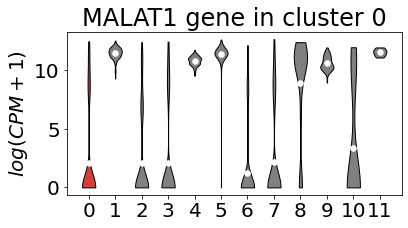

In [57]:
fig, ax = plt.subplots(figsize=(6, 3))

spec_c = markers_gene[markers_gene.gene_name=="MALAT1"]["leiden"].values[0]
spec_g = "MALAT1"

x = []
for c in unique:
    x.append(nd(data[data.obs.leiden==str(c)][:,data.var.gene_name==spec_g].layers["log1p"].todense()).tolist())
    
vplot_de(x, unique, spec_g, spec_c, ax=ax)

ax.set_ylabel("$log(CPM+1)$")

plt.show()

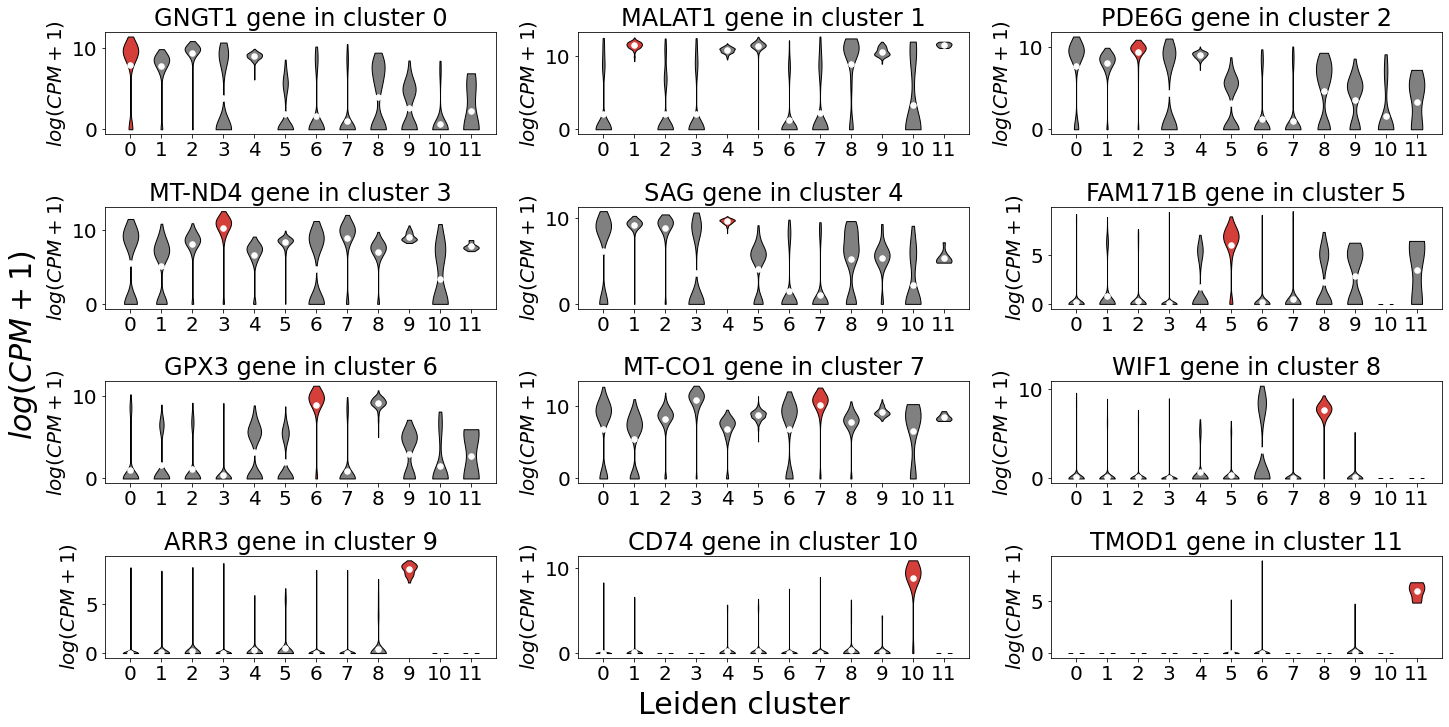

In [58]:
length = len(specific_cluster)*5
height = 3

fig, ax = plt.subplots(figsize=(20,10), ncols = 3, nrows=4)

axs = trim_axs(ax, len(specific_cluster))

for sn, (spec_c, spec_g) in enumerate(zip(specific_cluster, specific_gene)):
    x = []
    for c in unique:
        x.append(nd(data[data.obs.leiden==str(c)][:,data.var.gene_name==spec_g].layers["log1p"].todense()).tolist())
        
    vplot_de(x, unique, spec_g, spec_c, ax=axs[sn])
    
    
fig.text(0.5, 0, 'Leiden cluster', ha='center', va='center', fontsize=30)
fig.text(0, 0.5, '$log(CPM +1)$', ha='center', va='center', rotation='vertical', fontsize=30)
plt.tight_layout()

plt.show()

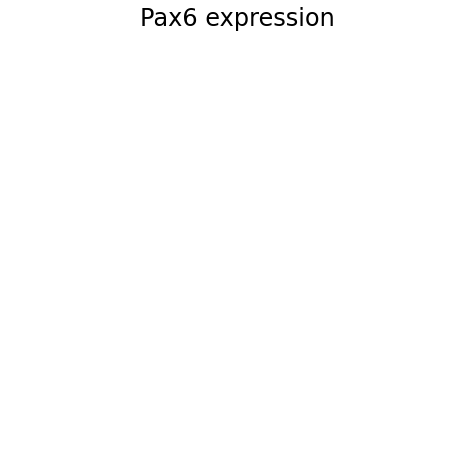

In [59]:
#Visualise expression of specific marker gene
gene = "Pax6"

fig, ax = plt.subplots(figsize=(7,7))

x = data.obsm["X_nca_tsne"][:,0]
y = data.obsm["X_nca_tsne"][:,1]
c = nd(data.layers["log1p"].todense()[:,data.var.gene_name==gene])

ax.scatter(x, y, c = c, cmap='Reds', alpha=0.5)

ax.set_axis_off()
ax.set_title("{} expression".format(gene))
plt.tight_layout()
plt.show()

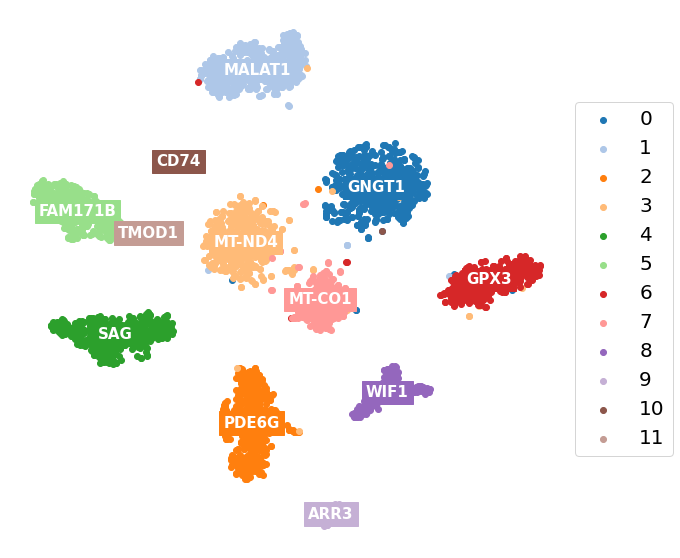

In [60]:
#Annotate clusters
fig, ax = plt.subplots(figsize=(10,10))

c = np.unique(data.obs["leiden"].values.astype(int)).astype(str)
cmap = cm.get_cmap("tab20")

for idx, (cluster, gene) in enumerate(zip(c, specific_gene)):
    XX = data[data.obs.leiden == cluster,:].obsm["X_nca_tsne"]
    
    x = XX[:,0]
    y = XX[:,1]
    ax.scatter(x, y, color = cmap(idx), label=cluster)
    ax.annotate(gene, 
             (np.mean(x), np.mean(y)),
             horizontalalignment='center',
             verticalalignment='center',
             size=15, weight='bold',
             color="white",
               backgroundcolor=cmap(idx)) 
    

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_axis_off()
plt.show()

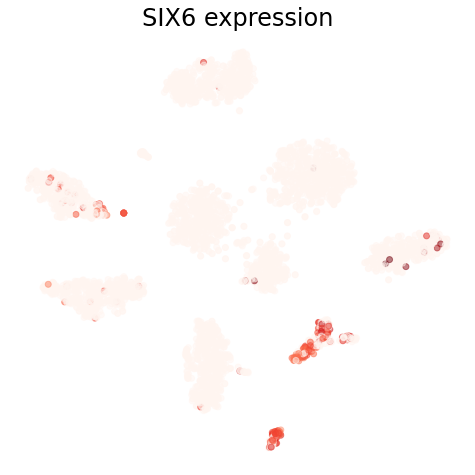

In [71]:
#Gene expression
gene = "SIX6"

fig, ax = plt.subplots(figsize=(7,7))

x = data.obsm["X_nca_tsne"][:,0]
y = data.obsm["X_nca_tsne"][:,1]
c = nd(data.layers["log1p"].todense()[:,data.var.gene_name==gene])

ax.scatter(x, y, c = c, cmap='Reds', alpha=0.5)

ax.set_axis_off()
ax.set_title("{} expression".format(gene))
plt.tight_layout()
plt.show()